<a href="https://colab.research.google.com/github/SalomoAgung/Big-Data-Analytics-for-Business-RMR/blob/main/Projek_Big_Data_Analytics_for_Business_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
#@title Get data
import gspread

#Authenticate Google Sheet
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

#Create Google Sheet in Google Drive
# sh = gc.create('NewGsheet')

#Get Google Sheet
worksheet = gc.open('NewGsheet').sheet1

# Get all sheet names within the spreadsheet
spreadsheet = gc.open('NewGsheet')
sheet_names = [sheet.title for sheet in spreadsheet.worksheets()]

# Print sheet names
print(sheet_names)

['Menu_dan_Porsi', 'Menu', 'Survey RMR', 'Pengeluaran', 'Pemasukan']


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
#@title Operational - Meal distribution

# Access individual sheets
menu_sheet = spreadsheet.worksheet('Menu')
survey_sheet = spreadsheet.worksheet('Survey RMR')

# Explicitly set headers for the 'Menu' sheet
menu_data = pd.DataFrame(
    menu_sheet.get_all_records(expected_headers=["Waktu", "Menu", "Jumlah"])
)

# Explicitly set headers for the 'Survey RMR' sheet
survey_data = pd.DataFrame(
    survey_sheet.get_all_records(expected_headers=["Jenis Kelamin", "Umur", "Pekerjaan/Status", "Makanan favorit"])
)

# Display the first few rows of each sheet to understand their structure
menu_data_head = menu_data.head()
survey_data_head = survey_data.head()

menu_data_head, survey_data_head

(  Waktu                Menu  Jumlah
 0  Juli     Nasi Sayur Asem     718
 1  Juli    Nasi Sop Sayuran     696
 2  Juli   Nasi Lodeh Kacang     524
 3  Juli          Nasi Pecel     363
 4  Juli  Nasi Rolade Daging     354,
              Timestamp     Nama  Umur Pekerjaan/Status  \
 0  04/12/2024 23:28:54    yusuf    46    driver shopee   
 1  04/12/2024 23:31:25   slamet    67          Pensiun   
 2  04/12/2024 23:32:54     Rudi    69        Pensiunan   
 3  04/12/2024 23:41:19  Choirul    35           Swasta   
 4  04/12/2024 23:42:16    mamat    64             guru   
 
   Tau rumah makan rakyat dari mana                         Makanan favorit  \
 0                   Mulut ke Mulut                     sayur, dadar jagung   
 1                   Mulut ke Mulut                          daging, bakwan   
 2               Sadar diri sendiri  Semua menu suka terutama sayur buncis.   
 3                   Mulut ke Mulut                                    Soto   
 4                        

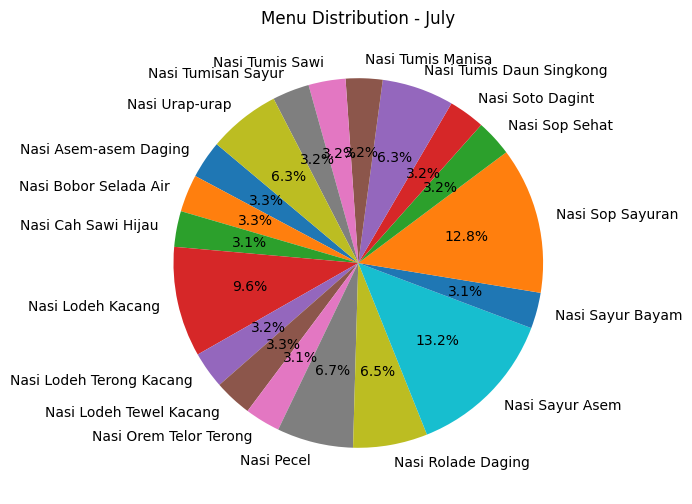

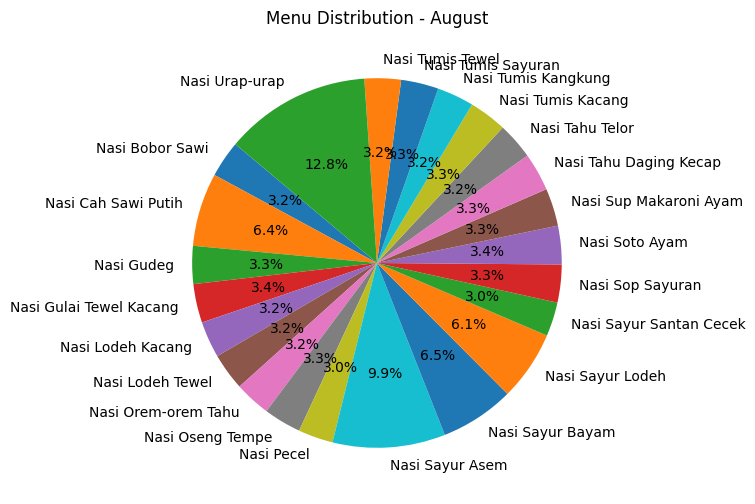

In [5]:
#Proses di bawah dilakukan untuk menggambarkan menu yang disajikan
menu_data.columns = ['Waktu', 'Menu', 'Jumlah']

# Filter data for July and August
july_data = menu_data[menu_data['Waktu'] == 'Juli']
august_data = menu_data[menu_data['Waktu'] == 'Agustus']

# Summarize menu quantities for both months
july_summary = july_data.groupby('Menu')['Jumlah'].sum()
august_summary = august_data.groupby('Menu')['Jumlah'].sum()

# Plot pie chart for July
plt.figure(figsize=(8, 6))
plt.pie(july_summary, labels=july_summary.index, autopct='%1.1f%%', startangle=140)
plt.title('Menu Distribution - July')
plt.show()

# Plot pie chart for August
plt.figure(figsize=(8, 6))
plt.pie(august_summary, labels=august_summary.index, autopct='%1.1f%%', startangle=140)
plt.title('Menu Distribution - August')
plt.show()

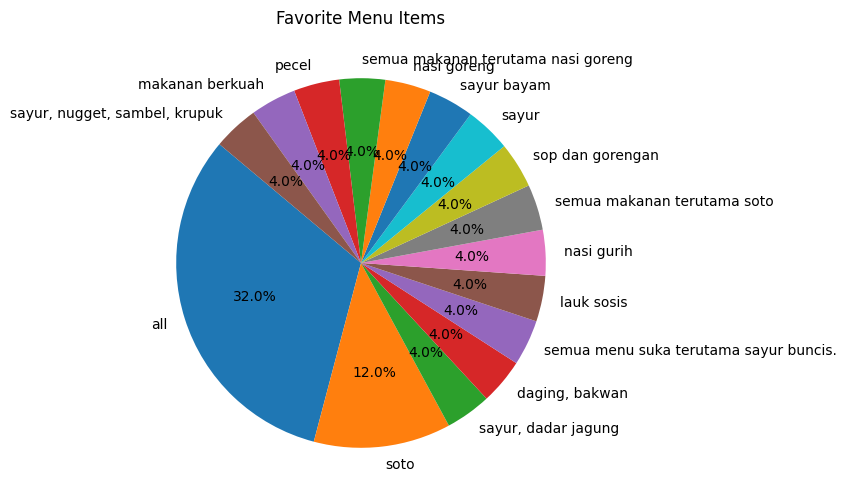

In [6]:
#visualisasi menu paling favorit
survey_data['Makanan favorit'] = survey_data['Makanan favorit'].str.lower()
survey_data['Makanan favorit'] = survey_data['Makanan favorit'].replace(
    {'bebas': 'all', 'semua makanan': 'all'}
)

# Count occurrences of each favorite menu
favorite_summary = survey_data['Makanan favorit'].value_counts()

# Plot the pie chart for favorite menu items
plt.figure(figsize=(8, 6))
plt.pie(favorite_summary, labels=favorite_summary.index, autopct='%1.1f%%', startangle=140)
plt.title('Favorite Menu Items')
plt.show()

In [7]:
#demand forecasting
from collections import Counter

# Menggabungkan semua makanan favorit menjadi satu list
all_favorite_foods = survey_data['Makanan favorit'].str.lower().str.split(',').sum()

# Menghitung frekuensi kemunculan setiap makanan
food_counts = Counter(all_favorite_foods)

# Mengurutkan makanan berdasarkan frekuensi, descending
sorted_foods = food_counts.most_common()

# Membuat DataFrame untuk hasil forecasting
forecast_df = pd.DataFrame(sorted_foods, columns=['Menu', 'Demand'])

# Menampilkan hasil forecasting
print(forecast_df)

# --- Pengelompokan Makanan ---
def group_food(food):
  if 'sayur' in food:
    return 'Sayuran'
  elif 'soto' in food:
    return 'Soto'
  elif 'ikan' in food:
    return 'Ikan'
  elif 'bebas' or 'semua' or 'all' in food:
    return 'All'
  else:
    return food

forecast_df['Kategori'] = forecast_df['Menu'].apply(group_food)

# Mengabaikan "All" pada saat printing
filtered_grouped_forecast = forecast_df[forecast_df['Kategori'] != 'All'].groupby('Kategori')['Demand'].sum().sort_values(ascending=False)

print("\nForecasting Menu Berdasarkan Kategori:")
print(filtered_grouped_forecast)

                                      Menu  Demand
0                                      all       8
1                                    sayur       3
2                                     soto       3
3                             dadar jagung       1
4                                   daging       1
5                                   bakwan       1
6   semua menu suka terutama sayur buncis.       1
7                               lauk sosis       1
8                               nasi gurih       1
9              semua makanan terutama soto       1
10                        sop dan gorengan       1
11                             sayur bayam       1
12                             nasi goreng       1
13      semua makanan terutama nasi goreng       1
14                                   pecel       1
15                         makanan berkuah       1
16                                  nugget       1
17                                  sambel       1
18                             

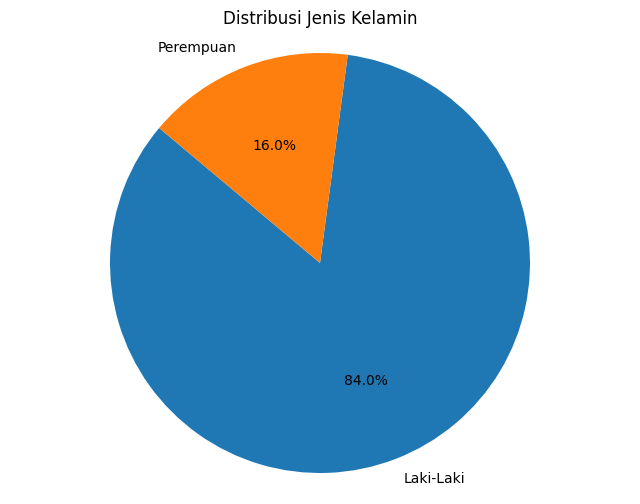

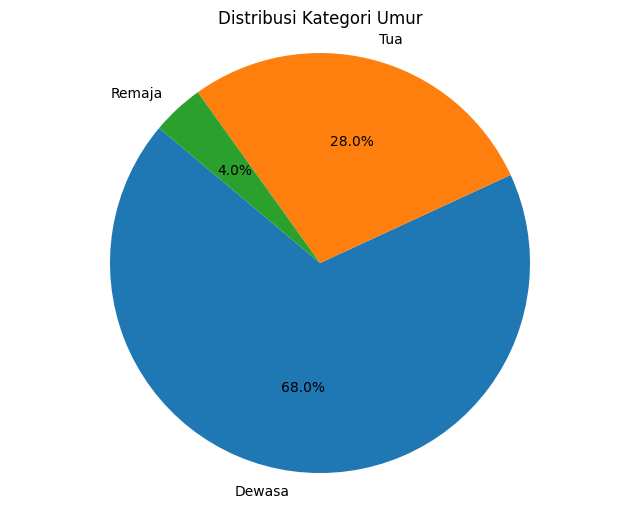

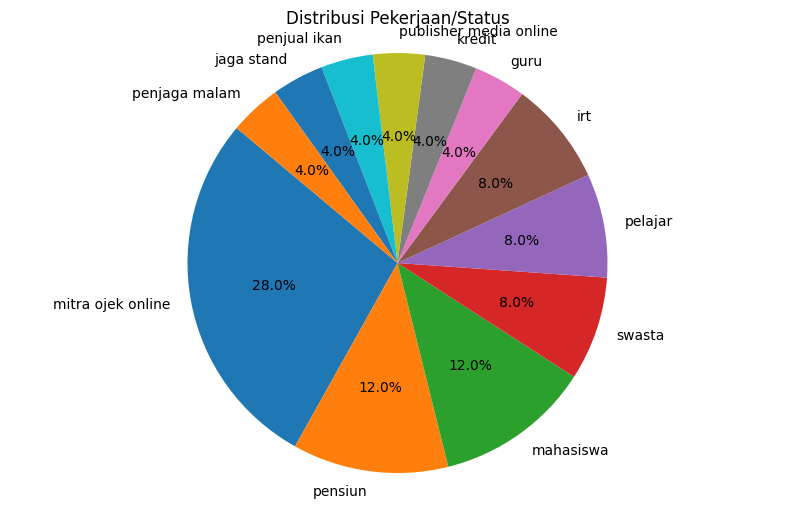

In [8]:
#@title Comunity Impact - Beneficiaries
#visualisasi demografi pengunjung
import seaborn as sns

# Preprocessing: Grouping jobs
# Preprocessing: Grouping jobs and cleaning up single-word entries
survey_data['Pekerjaan/Status'] = survey_data['Pekerjaan/Status'].str.lower()
survey_data['Pekerjaan/Status'] = survey_data['Pekerjaan/Status'].replace(
    to_replace=["driver shopee", 'driver gojek', 'ojek online', 'ojek'],
    value='mitra ojek online'
)

# Replace 'pensiunan' with 'pensiun'
survey_data['Pekerjaan/Status'] = survey_data['Pekerjaan/Status'].replace(
    to_replace='pensiunan',
    value='pensiun'
)

# Remove trailing spaces for single-word entries
survey_data['Pekerjaan/Status'] = survey_data['Pekerjaan/Status'].str.strip()

# Classification of age groups
def classify_age(age):
    if age <= 18:
        return 'Remaja'
    elif age <= 50:
        return 'Dewasa'
    else:
        return 'Tua'

survey_data['Kategori Umur'] = survey_data['Umur'].apply(classify_age)

# Visualisasi Jenis Kelamin
gender_counts = survey_data['Jenis Kelamin'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Jenis Kelamin')
plt.axis('equal') # Equal aspect ratio ensures that pie chart is circular.
plt.show()

# Visualisasi Kategori Umur
age_group_counts = survey_data['Kategori Umur'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Kategori Umur')
plt.axis('equal')
plt.show()

# Visualisasi Pekerjaan/Status
job_counts = survey_data['Pekerjaan/Status'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(job_counts, labels=job_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Pekerjaan/Status')
plt.axis('equal')
plt.show()

In [9]:
#@title Donor data - Donation

# Akses sheet 'Pemasukan'
pemasukan_sheet = spreadsheet.worksheet('Pemasukan')
pemasukan_df = pd.DataFrame(
    pemasukan_sheet.get_all_records(expected_headers=["No.", "No. Account", "Kode", "Nama", "Alamat", "Kota",
                                                      "No. Telepon", "Saldo", "Tipe Pemasukan", "Per Tanggal"])
)

# # Konversi kolom 'Saldo' ke numerik
pemasukan_df["Saldo"] = pemasukan_df["Saldo"].replace('[Rp,.]', '', regex=True).astype(float)

# Konversi 'Per Tanggal' menjadi tipe datetime
pemasukan_df["Per Tanggal"] = pd.to_datetime(pemasukan_df["Per Tanggal"], format='%d/%m/%Y')

# Ekstraksi bulan dari kolom 'Per Tanggal'
pemasukan_df["Bulan"] = pemasukan_df["Per Tanggal"].dt.strftime('%B')

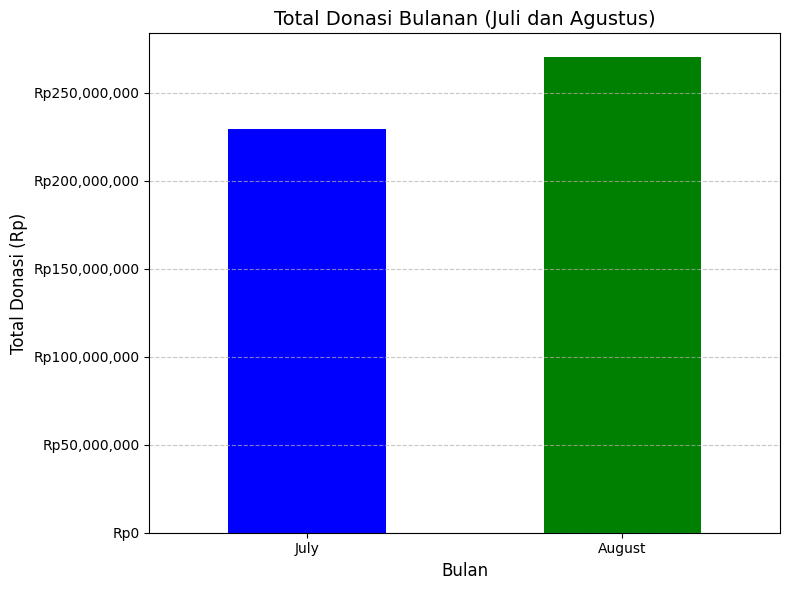

,Saldo
Bulan,
July,229512371.0
August,270299471.0


In [10]:
# Menghitung total saldo per bulan
total_donasi_bulanan = pemasukan_df.groupby("Bulan")["Saldo"].sum().reindex(["July", "August"])

# Membuat bar chart
plt.figure(figsize=(8, 6))
total_donasi_bulanan.plot(kind='bar', color=['blue', 'green'])

# Menyesuaikan format tampilan
plt.title("Total Donasi Bulanan (Juli dan Agustus)", fontsize=14)
plt.ylabel("Total Donasi (Rp)", fontsize=12)
plt.xlabel("Bulan", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan format Rupiah di sumbu Y
from matplotlib.ticker import FuncFormatter

formatter = FuncFormatter(lambda x, _: f'Rp{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

# Menampilkan total donasi untuk validasi
total_donasi_bulanan

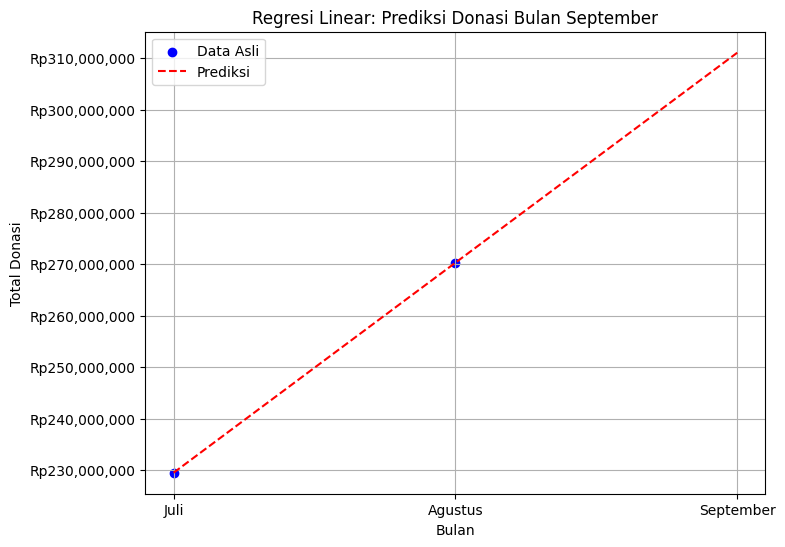

Prediksi donasi bulan September: Rp311,086,571.00


In [11]:
#donation forecasting
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker

# Preprocessing data pemasukan
pemasukan_df["Per Tanggal"] = pd.to_datetime(pemasukan_df["Per Tanggal"], format="%d/%m/%Y")
pemasukan_df["Bulan Index"] = pemasukan_df["Per Tanggal"].dt.month

# Menghitung total saldo per bulan
total_donasi_bulanan = pemasukan_df.groupby("Bulan Index")["Saldo"].sum().reset_index()

# Menyiapkan data untuk regresi
X = total_donasi_bulanan["Bulan Index"].values.reshape(-1, 1)
y = total_donasi_bulanan["Saldo"].values

# Model Linear Regression
model = LinearRegression()
model.fit(X, y)

# Forecast untuk bulan September (Bulan Index = 9)
predicted_september = model.predict([[9]])[0]

# Visualisasi data dan prediksi
plt.figure(figsize=(8, 6))
plt.scatter(total_donasi_bulanan["Bulan Index"], total_donasi_bulanan["Saldo"], color="blue", label="Data Asli")
plt.plot(range(7, 10), model.predict(np.array([7, 8, 9]).reshape(-1, 1)), color="red", linestyle="--", label="Prediksi")

# Sesuaikan format sumbu Y ke Rupiah
ax = plt.gca()
formatter = ticker.FuncFormatter(lambda x, _: f"Rp{x:,.0f}")
ax.yaxis.set_major_formatter(formatter)

# Menyesuaikan sumbu X untuk nama bulan
plt.xticks([7, 8, 9], ['Juli', 'Agustus', 'September'])
plt.xlabel("Bulan")
plt.ylabel("Total Donasi")
plt.title("Regresi Linear: Prediksi Donasi Bulan September")
plt.legend()
plt.grid()
plt.show()

print(f"Prediksi donasi bulan September: Rp{predicted_september:,.2f}")

In [16]:
# Install library jika belum ada
!pip install scikit-learn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Ambil data dari Google Spreadsheet
pemasukan_sheet = spreadsheet.worksheet("Pemasukan")

# Konversi data dari Spreadsheet menjadi DataFrame
pemasukan_data = pd.DataFrame(
    pemasukan_sheet.get_all_records(
        expected_headers=[
            "No.", "No. Account", "Kode", "Nama", "Alamat", "Kota", "No. Telepon", "Saldo", "Tipe Pemasukan", "Per Tanggal",
        ]
    )
)

# Pastikan kolom "Saldo" adalah numerik, gunakan errors='coerce' untuk menangani data yang tidak valid
pemasukan_data["Saldo"] = pd.to_numeric(pemasukan_data["Saldo"], errors="coerce")

# Buang baris dengan Nama atau Saldo yang kosong
pemasukan_data = pemasukan_data.dropna(subset=["Nama", "Saldo"])

# Hitung total frekuensi dan jumlah donasi per donatur
donatur_summary = pemasukan_data.groupby("Nama")["Saldo"].agg(["count", "sum"]).reset_index()
donatur_summary.columns = ["Nama", "Frekuensi", "Saldo"]  # Beri nama ulang kolom hasil grup

# Hitung rata-rata donasi untuk klasifikasi
average_donation = donatur_summary["Saldo"].mean()

# Buat kolom Label untuk klasifikasi (Loyal atau Biasa)
donatur_summary["Label"] = donatur_summary.apply(
    lambda row: "Loyal" if row["Frekuensi"] > 1 and row["Saldo"] > average_donation else "Biasa", axis=1
)

# Siapkan data fitur (X) dan label (y)
X = donatur_summary[["Frekuensi", "Saldo"]]
y = donatur_summary["Label"].map({"Loyal": 1, "Biasa": 0})  # Encode label (Loyal=1, Biasa=0)

# Bagi data menjadi training dan testing (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inisialisasi model Naive Bayes
model = GaussianNB()
model.fit(X_train, y_train)

# Prediksi pada data test
y_pred = model.predict(X_test)

# Evaluasi performa model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Prediksi untuk semua data
donatur_summary["Predicted Label"] = model.predict(X)

# Decode hasil prediksi untuk interpretasi
donatur_summary["Predicted Label"] = donatur_summary["Predicted Label"].map({1: "Loyal", 0: "Biasa"})

# Ambil 5 donatur loyal dan 5 donatur biasa
donatur_loyal = donatur_summary[donatur_summary["Predicted Label"] == "Loyal"].head(5)
donatur_biasa = donatur_summary[donatur_summary["Predicted Label"] == "Biasa"].head(5)

# Tampilkan hasil
print("5 Donatur Loyal:")
print(donatur_loyal)

print("\n5 Donatur Biasa:")
print(donatur_biasa)

Accuracy: 0.9424460431654677

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       126
           1       0.86      0.46      0.60        13

    accuracy                           0.94       139
   macro avg       0.90      0.73      0.78       139
weighted avg       0.94      0.94      0.93       139

5 Donatur Loyal:
                             Nama  Frekuensi       Saldo  Label  \
71            Budi Ardiansyah. Bp          4   7500000.0  Loyal   
75     Christiane Fitri Slat. Ibu          5   9500000.0  Loyal   
96      Durrotun Nasicha. Hj. Ibu          3   4200000.0  Loyal   
108        Dyah Ratnaningsih. Ibu          4  32160000.0  Loyal   
150  GeMeS (G. Memuliakan Santri)          2   4710000.0  Loyal   

    Predicted Label  
71            Loyal  
75            Loyal  
96            Loyal  
108           Loyal  
150           Loyal  

5 Donatur Biasa:
                     Nama  Frekuensi     Saldo  L

In [ ]:
#financial-expense

# Access individual sheets
pengeluaran_sheet = spreadsheet.worksheet('Pengeluaran')

pengeluaran_data = pd.DataFrame(
    pengeluaran_sheet.get_all_records(expected_headers=["No. Account", "Nama Pengeluaran", "Periode Juni", "Periode Juli", "Periode Agustus"])
)

df_pengeluaran = pd.DataFrame(pengeluaran_data)
df_pengeluaran.columns = ['No. Account', 'Nama Pengeluaran', 'Juni', 'Juli', 'Agustus']
print(df_pengeluaran)

  No. Account                   Nama Pengeluaran      Juni      Juli  Agustus
0   120.03.01              Persediaan Bahan Baku   5956500   5361500  5785000
1      210.01         Titipan Uang Belanja Bahan  13050000  16750000  9450000
2   400.09.01    Biaya Bahan Baku & Pembantu RMR  11837500   5937000  5340500
3   700.01.01                        Gaji / Upah   5050000   5200000  4365000
4   700.02.06  Listrik, Air & Kebersihan (Paket)    350000    350000   350000
5   700.02.09           Inventaris/Peralatan RMR     95000   1605000    41000
6   700.03.02        Sawa Bangunan (Rumah Makan)    500000    500000   500000
7   800.02.04            Biaya Administrasi Bank     27500     37500    14024


In [ ]:
# Hitung Growth Rate
df_pengeluaran["Growth Rate"] = (df_pengeluaran["Agustus"] - df_pengeluaran["Juni"]) / 2

# Forecast bulan September
df_pengeluaran["Forecast September"] = df_pengeluaran["Agustus"] + df_pengeluaran["Growth Rate"]

# Hitung Growth Rate dalam persen
df_pengeluaran["Growth Rate (%)"] = df_pengeluaran.apply(
    lambda row: (row["Growth Rate"] / row["Juni"] * 100) if pd.notna(row["Juni"]) and row["Juni"] != 0 else None,
    axis=1
)

# Tampilkan hasil
print(df_pengeluaran[["No. Account", "Nama Pengeluaran", "Juni", "Juli", "Agustus", "Forecast September", "Growth Rate (%)"]])

  No. Account                   Nama Pengeluaran      Juni      Juli  Agustus  \
0   120.03.01              Persediaan Bahan Baku   5956500   5361500  5785000   
1      210.01         Titipan Uang Belanja Bahan  13050000  16750000  9450000   
2   400.09.01    Biaya Bahan Baku & Pembantu RMR  11837500   5937000  5340500   
3   700.01.01                        Gaji / Upah   5050000   5200000  4365000   
4   700.02.06  Listrik, Air & Kebersihan (Paket)    350000    350000   350000   
5   700.02.09           Inventaris/Peralatan RMR     95000   1605000    41000   
6   700.03.02        Sawa Bangunan (Rumah Makan)    500000    500000   500000   
7   800.02.04            Biaya Administrasi Bank     27500     37500    14024   

   Forecast September  Growth Rate (%)  
0           5699250.0        -1.439604  
1           7650000.0       -13.793103  
2           2092000.0       -27.442450  
3           4022500.0        -6.782178  
4            350000.0         0.000000  
5             14000.0   

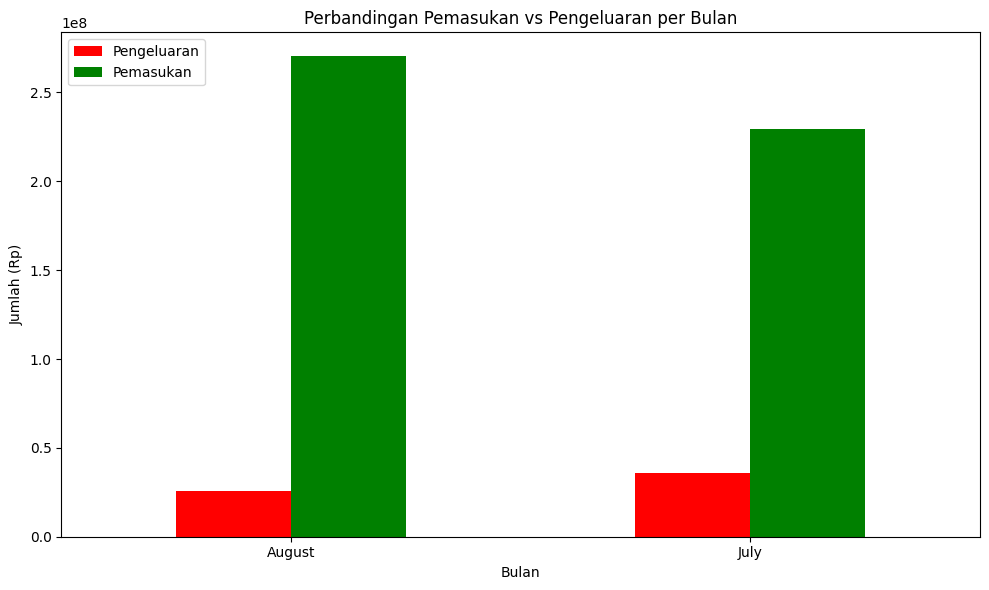

In [ ]:
#@title Financial - Budgeting

#Pemasukan vs Pengeluaran

# Grouping pemasukan berdasarkan bulan
pemasukan_periode = pemasukan_df.groupby("Bulan")["Saldo"].sum()

# Visualisasi pemasukan vs pengeluaran
import matplotlib.pyplot as plt

# Data pengeluaran dari sheet
pengeluaran_sheet = spreadsheet.worksheet('Pengeluaran')
pengeluaran_df = pd.DataFrame(
    pengeluaran_sheet.get_all_records(expected_headers=["No. Account", "Nama Pengeluaran",
                                                        "Periode Juli", "Periode Agustus"])
)

# Total pengeluaran per bulan
pengeluaran_periode = {
    "July": pengeluaran_df["Periode Juli"].sum(),
    "August": pengeluaran_df["Periode Agustus"].sum(),
}

# Konversi pemasukan dan pengeluaran ke DataFrame
comparison_df = pd.DataFrame({
    "Pengeluaran": pd.Series(pengeluaran_periode),
    "Pemasukan": pemasukan_periode
}).fillna(0)

# Plot bar chart pemasukan vs pengeluaran
comparison_df.plot(kind="bar", figsize=(10, 6), color=["red", "green"])
plt.title("Perbandingan Pemasukan vs Pengeluaran per Bulan")
plt.xlabel("Bulan")
plt.ylabel("Jumlah (Rp)")
plt.xticks(rotation=0)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()